# Tesis de Licenciatura en Astronomía

## Manuel López Vargas

# Detección de señales en series de tiempo astronómicas utilizando algoritmos de Machine Learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.signal as signal
from astropy.timeseries import LombScargle
from gatspy.periodic import LombScargleFast
from gatspy import datasets, periodic
import sympy
from scipy.integrate import odeint
from scipy import integrate
from mpl_toolkits.mplot3d.axes3d import Axes3D
import random
from operator import itemgetter

In [2]:
A = 3
B = 4
C = 4
w1 = 3.2 #rad/sec
w2 = 2.3 #rad/sec
w3 = 2.9 #rad/sec
psi1 = 1. #rad
psi2 = 1.8 #rad
n_in = 300
n_out = 100000

In [52]:
2/w1, 1/w2, 1/w3

(0.6097560975609756, 0.4347826086956522, 0.7692307692307692)

Generamos aleatoriamente tiempos de muestreo.

In [593]:
seed_value = 1 
rng = np.random.default_rng(seed_value)
t = rng.uniform(0, 10*np.pi, n_in)

Ploteamos dos ondas sinusoidales con freciencias diferentes ($\frac{w1}{w2}\neq Q$) para los tiempos seleccionados.

In [594]:
x = A * np.sin(w1*t + psi1) + B * np.sin(w2*t + psi2) 

Definimos un arreglo de frecuencias para el que se calculará el periodograma

In [330]:
w = np.linspace(0.0001, 10, n_out)
periods = 2 * np.pi / w

Calculamos el error en frecuencia

In [331]:
err = w[1]-w[0]
err

0.0001

Calculo el Lomb-Scargle periodograma

In [332]:
pgram = signal.lombscargle(t, x, w, normalize=True)

Ploteo los datos de salida

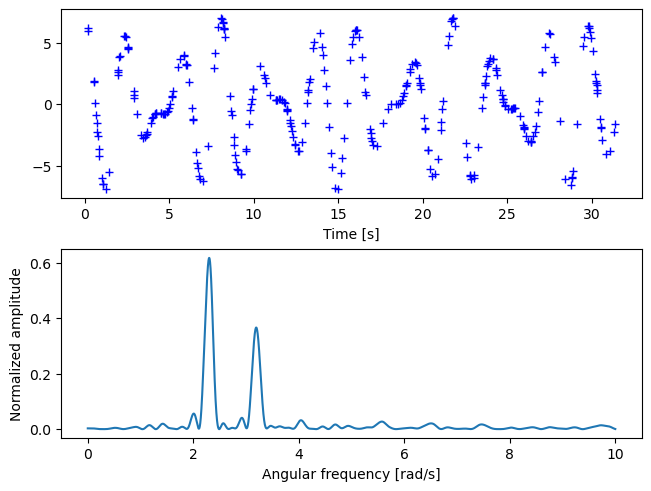

In [333]:
fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
plt.show();

Los resultados no cambian cuando $(\frac{w1}{w2}= Q)$

Probamos con otro codigo.

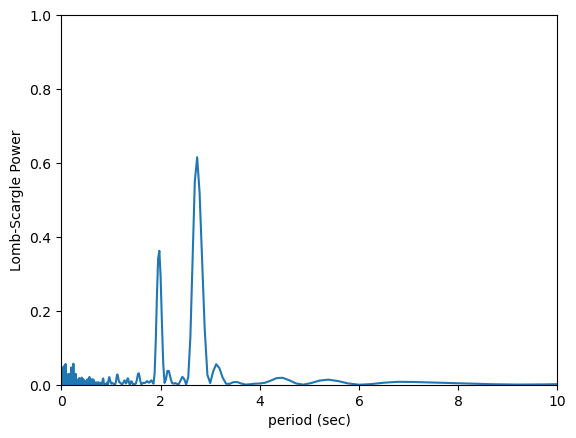

In [339]:
model = LombScargleFast().fit(t, x)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1.0),
        xlabel='period (sec)',
        ylabel='Lomb-Scargle Power');

In [335]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 2 #limite infererior del intervalo
f_end = 2.5 #limite superior del intervalo

model = periodic.LombScargleFast()
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=1)
model.fit(t, x)          
nu = model.best_period

print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.201
 - Using 1 steps per peak; omega_step = 0.201
 - User-specified period range:  1.9 to 2.5
 - Computing periods at 5 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 4995 steps
La frecuencia encontrada es: 2.7177522908802163


#### Calculamos la False-Alarm Probablility (FAP).

La FAP se define como FAP(z) = $1 - [P_{single0}(z)]^{N_{eff.}}$ donde $N_{eff.}= f_{max}T$

Utilizando la libreria astropy.timeseries vamos a calcular la FAP.

In [336]:
ls = LombScargle(t, x)
freq, power = ls.autopower()
print(power.max())  

0.6174496473417987


In [337]:
fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

FAP = 1.2847028365191885e-58


Lo que esto nos dice es que, suponiendo que no haya una señal periódica en los datos, observaremos un pico tan alto o más con una probabilidad de $3.118\ x10^{-22}$, lo que nos da una fuerte indicación de que hay una señal periódica presente en los datos.

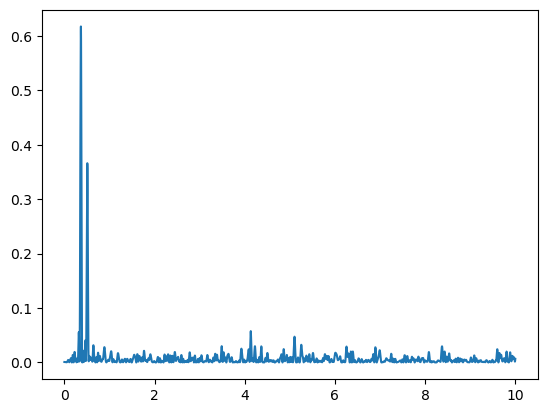

In [338]:
plt.plot(w,power);

In [597]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.11956825, 0.12864355, 0.14872932])

## Ahora simularemos nuestros datos utilizando potenciales con simetria esférica.

### Probamos primero con el siguiente potencial:

### $\phi(r) = -\frac{GM}{r} $

Luego

### $\ddot{x} = - \nabla \phi(r)$

Podemos descomponer esta ecuación diferencial de segundo orden en dos ecuaciones de primer orden.

### $\dot{x} = v\ \ \ ,\ \ x(0) = x_0$
### $\dot{v} = -\nabla \phi\ \ \ , \ \ \dot{x}(0) = \dot{x}_0$

Planteamos las condiciones iniciales.

### $X_o$=1  ,   $Y_o$=0
### $\dot{X_0}$=0  ,   $\dot{Y_0}$=0.1

### GM=1

Resolvemos las ecuaciones diferenciales acopladas de forma numérica:

In [275]:
# Elegimos los tiempos de observación t
seed_value = 10 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 15, n_in)

In [276]:
t.sort()

In [277]:
# Definimos el sistema de ecuaciones
def f(xyv_xv_y, t):
    x, y, v_x, v_y = xyv_xv_y
    return [v_x, 
           v_y,
           -x/(x**2+y**2)**(3/2),
           -y/(x**2+y**2)**(3/2)]


# Condiciónes iniciales
xyv_xv_y0 = [1.0, 0., 0., 0.1]

# Resolvemos las ecuaciones
xyv_xv_y1 = integrate.odeint(f, xyv_xv_y0, t)

In [278]:
x_1 = xyv_xv_y1[:,0]
y_1 = xyv_xv_y1[:,1]
v_x_1 = xyv_xv_y1[:,2]
v_y_1 = xyv_xv_y1[:,3]

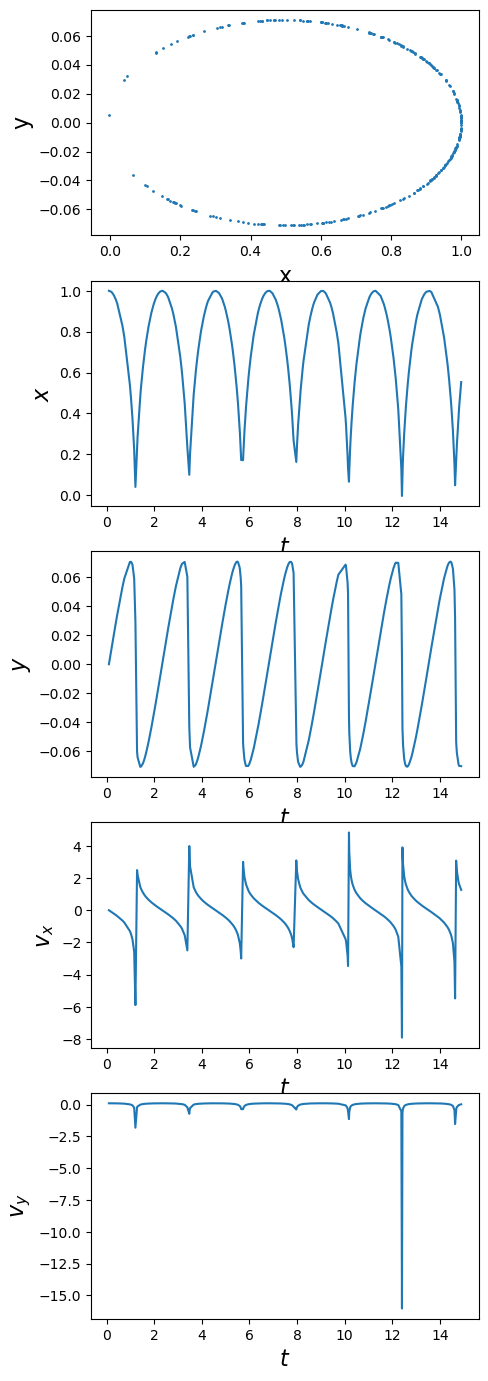

In [279]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(x_1,y_1, 'o', ms=1)
ax2.plot(t, x_1)
ax3.plot(t, y_1)
ax4.plot(t, v_x_1)
ax5.plot(t, v_y_1)

ax1.set_ylabel('y', fontsize=16)
ax1.set_xlabel('x', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax4.set_ylabel('$v_x$', fontsize=16)
ax5.set_ylabel('$v_y$', fontsize=16);

Con esto, calculamos el periodograma para las coordenadas x e y:

#### Coordenada X

In [345]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.0001, 10, n_out)
periods = 2 * np.pi / w

# Calculamos el error en frecuencia
err= w[1]-w[0]
err

0.0001

In [346]:
xx= x_1-x_1.mean()

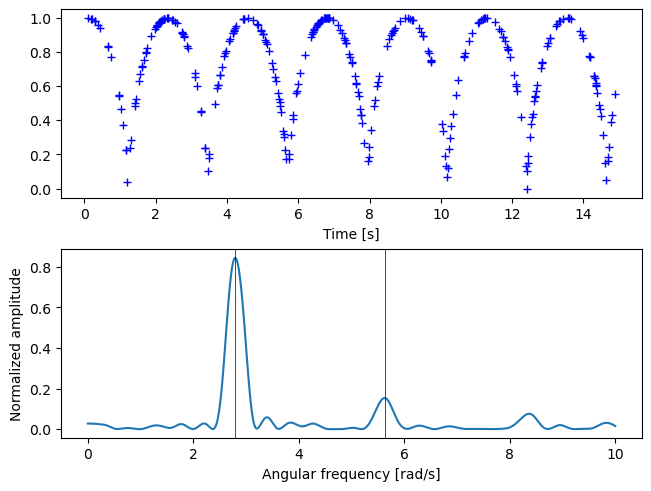

In [347]:
pgram = signal.lombscargle(t, xx, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x_1, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')

ax_w.axvline(2.795, color= 'black' ,lw=0.5)
ax_w.axvline(5.627, color= 'black' ,lw=0.5);

Buscamos el valor de la frecuencia del pico mas alto:

In [348]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 2.7950000000000004 0.0001


Buscamos el valor de la frecuencia del segundo pico:

In [349]:
pgram2 = np.where(w> 4, pgram, pgram*0)

pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 5.627 0.0001


Probamos con otro paquete el algoritmo Lomb-Scargle

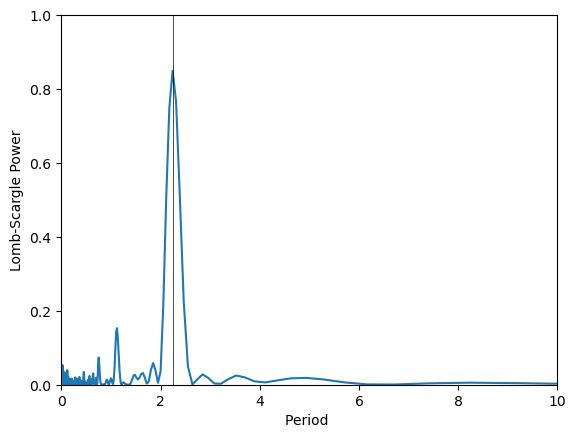

In [350]:
model = LombScargleFast().fit(t, xx)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1),
        xlabel='Period ',
        ylabel='Lomb-Scargle Power')
plt.axvline(2.24186, color= 'black' ,lw=0.5, label=('FAP 1%'));

In [351]:
power_sort = sorted(enumerate(power), key=itemgetter(1),  reverse=True)
index, value = power_sort[0]
print(r'La frecuencia encontrada es', 2*np.pi/periods[index])

La frecuencia encontrada es 2.8026641453464745


In [352]:
ls = LombScargle(t, xx, normalization='standard')
power = ls.power(w)
print('Altura del pico máximo:',power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

Altura del pico máximo: 0.8498833553504532
FAP = 1.106485912553035e-118


In [353]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.06548677, 0.070241  , 0.0808616 ])

Vemos que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06548; para el 5%, 0,07024, y para el 1%, 0,08086.

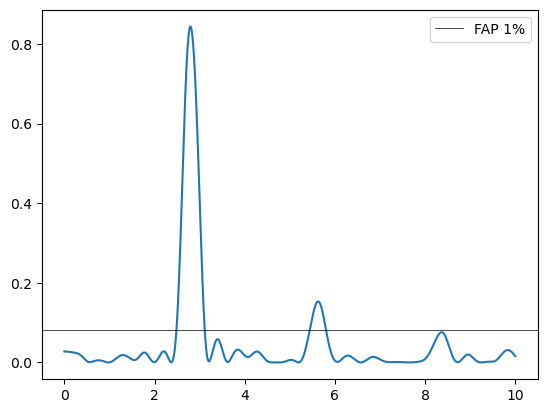

In [354]:
plt.plot(w,pgram)
plt.axhline(0.08086, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron dos picos con una FAP menos a 1%. Pero la que nos interes es el pico mas alto.

#### Coordenada Y

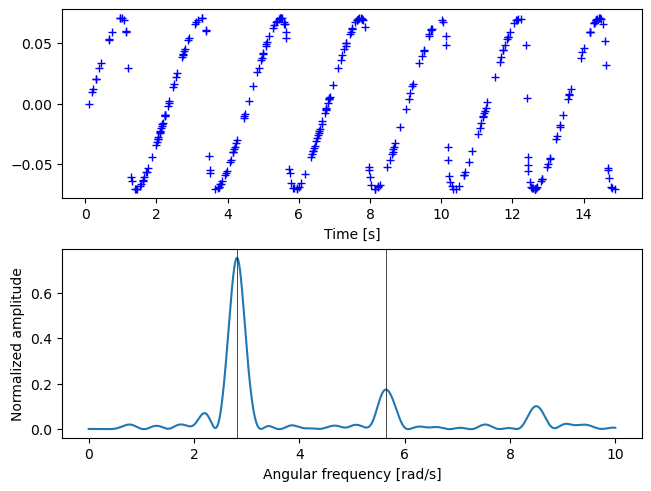

In [355]:
pgram = signal.lombscargle(t, y_1, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, y_1, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')

ax_w.axvline(2.8161, color= 'black' ,lw=0.5)
ax_w.axvline(5.6451, color= 'black' ,lw=0.5);

Buscamos el valor de la frecuencia del pico mas alto:

In [356]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 2.8161000000000005 0.0001


Buscamos el valor de la frecuencia del segundo pico:

In [357]:
pgram2 = np.where(w> 4, pgram, pgram*0)

pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 5.6451 0.0001


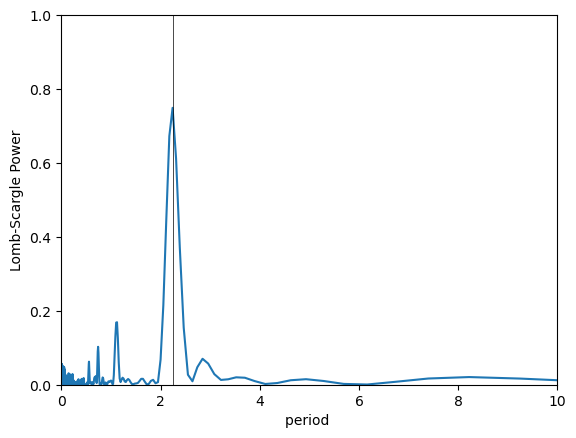

In [358]:
model = LombScargleFast().fit(t, y_1)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power')
ax.axvline(2.24186, color= 'black' ,lw=0.5);

In [359]:
power_sort = sorted(enumerate(power), key=itemgetter(1),  reverse=True)
index, value = power_sort[0]
print(r'El periodo encontrado es', 2*np.pi/periods[index])

El periodo encontrado es 2.8026641453464745


In [360]:
ls = LombScargle(t, y_1, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.7522917421211716
FAP = 1.618783342368678e-86


In [361]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.06548677, 0.070241  , 0.0808616 ])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,0658; para el 5%, 0,0706, y para el 1%, 0,0812.

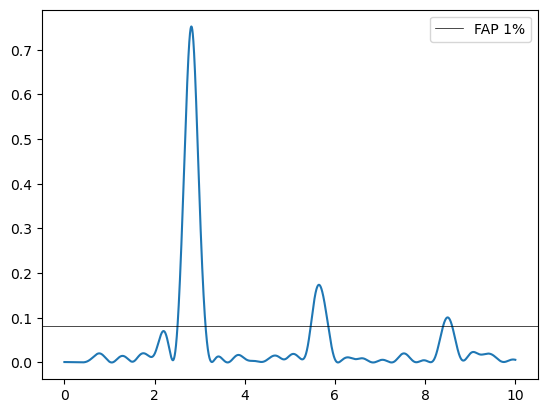

In [362]:
plt.plot(w,pgram)
plt.axhline(0.08086, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron tres picos con una FAP menos a 1%. Pero la que nos interes es el pico mas alto.

## Pasamos a un potencial de la forma:

### $\phi =\frac{1}{2} \Omega² r²$

#### Luego, resolvemos el mismo sistema de ec. diferenciales para el $\phi$ mencionado.

In [363]:
# Elegimos los tiempos de observación t
seed_value = 20 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 15, n_in)

In [364]:
t.sort()

In [365]:
# Definimos el sistema de ecuaciones
def f(xyv_xv_y, t, omega, a):
    x, y, v_x, v_y = xyv_xv_y
    return [v_x, 
           v_y,
           a-omega**2 *x,
           a-omega**2 *y]


# Condiciónes iniciales
xyv_xv_y0 = [1.0, 0., 0., 0.1]
omega=np.sqrt(2)
a=0

# Resolvemos las ecuaciones
xyv_xv_y2 = integrate.odeint(f, xyv_xv_y0, t, args=(omega, a))

In [366]:
x_2 = xyv_xv_y2[:,0]
y_2 = xyv_xv_y2[:,1]
v_x_2 = xyv_xv_y2[:,2]
v_y_2 = xyv_xv_y2[:,3]

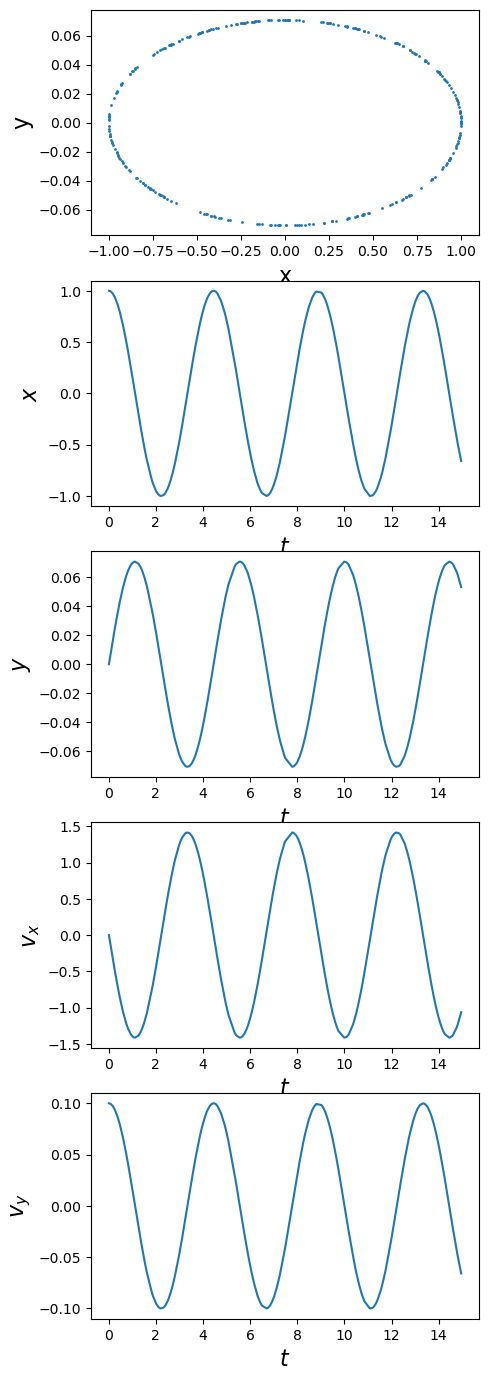

In [367]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(x_2,y_2, 'o', ms=1)
ax2.plot(t, x_2)
ax3.plot(t, y_2)
ax4.plot(t, v_x_2)
ax5.plot(t, v_y_2)

ax1.set_ylabel('y', fontsize=16)
ax1.set_xlabel('x', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax4.set_ylabel('$v_x$', fontsize=16)
ax5.set_ylabel('$v_y$', fontsize=16);

Con esto, calculamos el periodograma para las coordenadas x e y:

#### Coordenada X

In [368]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.0001, 10, n_out)
periods = 2 * np.pi / w

# Calculamos el error en frecuencia
err= w[1]-w[0]
err

0.0001

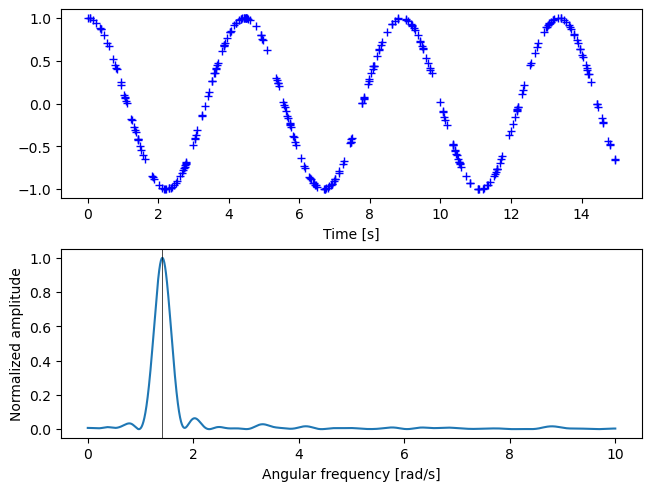

In [373]:
pgram = signal.lombscargle(t, x_2, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x_2, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')

ax_w.axvline(1.4142, color= 'black' ,lw=0.5);

Buscamos el valor de la frecuencia del pico mas alto:

In [371]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.4142000000000001 0.0001


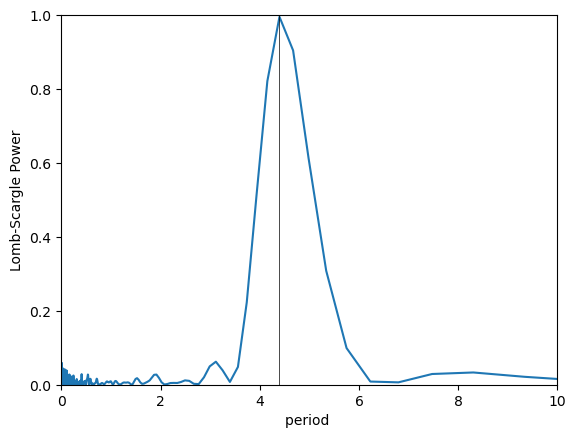

In [377]:
model = LombScargleFast().fit(t, x_2)
periods, power = model.periodogram_auto(nyquist_factor=15)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power')
ax.axvline(4.3964, color= 'black' ,lw=0.5);

Buscamos el valor de la frecuencia del pico mas alto:

In [378]:
power_sort = sorted(enumerate(power), key=itemgetter(1),  reverse=True)
index, value = power_sort[0]
print(r'La frecuencia encontrada es', 2*np.pi/periods[index])

La frecuencia encontrada es 1.4291443298657844


In [379]:
ls = LombScargle(t, x_2, normalization='standard')
power = ls.power(w)
print('Altura del pico máximo:',power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

Altura del pico máximo: 0.9999996697283257
FAP = 0.0


In [382]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.06549422, 0.07024839, 0.08086886])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,0652; para el 5%, 0,07, y para el 1%, 0,0806.

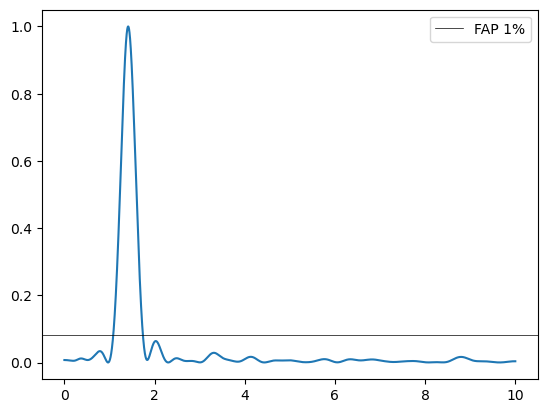

In [381]:
plt.plot(w,pgram)
plt.axhline(0.08086, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontro un solo pico con un FAP menor al 1%.

#### Coordenada Y

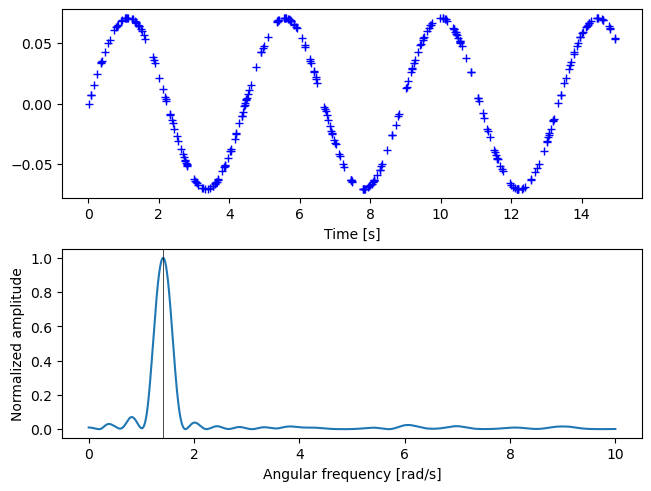

In [385]:
pgram = signal.lombscargle(t, y_2, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, y_2, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')

ax_w.axvline(1.4142, color= 'black' ,lw=0.5);

Buscamos el valor de la frecuencia del pico mas alto:

In [384]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.4142000000000001 0.0001


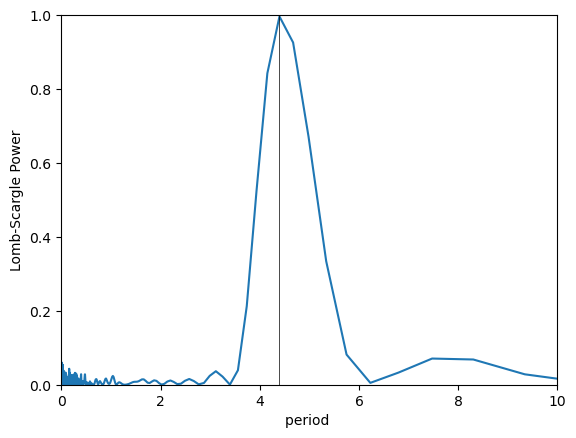

In [389]:
model = LombScargleFast().fit(t, y_2)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power')
ax.axvline(4.3964, color= 'black' ,lw=0.5);

Buscamos el valor de la frecuencia del pico mas alto:

In [390]:
power_sort = sorted(enumerate(power), key=itemgetter(1),  reverse=True)
index, value = power_sort[0]
print(r'El periodo encontrado es', 2*np.pi/periods[index])

El periodo encontrado es 1.4291443298657844


In [391]:
ls = LombScargle(t, y_2, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.9999997473091077
FAP = 0.0


In [392]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.06549422, 0.07024839, 0.08086886])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,0652; para el 5%, 0,07, y para el 1%, 0,0806.


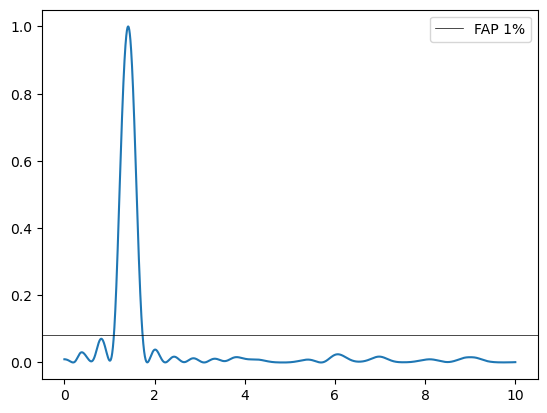

In [393]:
plt.plot(w,pgram)
plt.axhline(0.08086, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontro un solo pico con un FAP menor al 1%.

### Pasamos ahora a un potencial de la forma:

### $\phi = \frac{-GM}{\sqrt{b²+r²}}$

Resolvemos el sistema de ecuaciones diferenciales

In [38]:
# Elegimos los tiempos de observación t
seed_value = 30 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 20, n_in)

In [39]:
t.sort()

In [40]:
# Definimos el sistema de ecuaciones

def f(xyv_xv_y, t, b, a):
    x, y, v_x, v_y = xyv_xv_y
    return [v_x, 
           v_y,
           -x/(a*b**2+x**2+y**2)**(3/2),
           -y/(b**2+x**2+y**2)**(3/2)]

b, a = 0.1, 1

# Condiciónes iniciales
xyv_xv_y0 = [1.0, 0., 0., 0.1]

# Resolvemos las ecuaciones
xyv_xv_y3 = integrate.odeint(f, xyv_xv_y0, t, args=(b,a))

In [41]:
x_3 = xyv_xv_y3[:,0]
y_3 = xyv_xv_y3[:,1]
v_x_3 = xyv_xv_y3[:,2]
v_y_3= xyv_xv_y3[:,3]

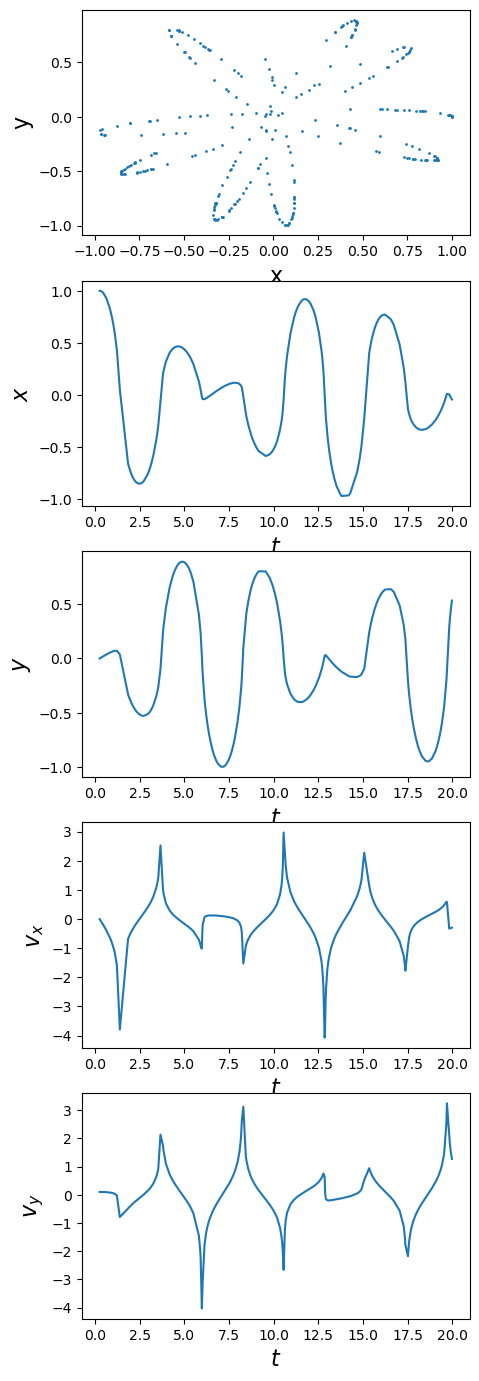

In [42]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(x_3,y_3, 'o', ms=1)
ax2.plot(t, x_3)
ax3.plot(t, y_3)
ax4.plot(t, v_x_3)
ax5.plot(t, v_y_3)

ax1.set_ylabel('y', fontsize=16)
ax1.set_xlabel('x', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax4.set_ylabel('$v_x$', fontsize=16)
ax5.set_ylabel('$v_y$', fontsize=16);

Calculamos el periodograma para las coordenadas x e y:

#### Coordenada X

In [43]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.0001, 10, n_out)
periods = 2 * np.pi / w

# Calculamos el error en frecuencia
err= w[1]-w[0]
err

0.0001

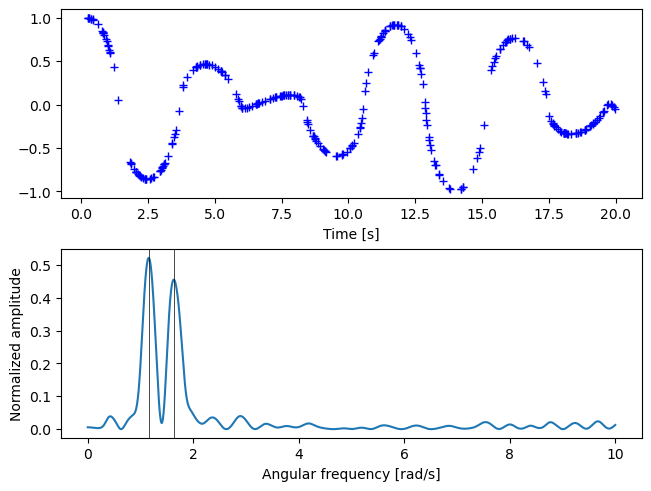

In [44]:
pgram = signal.lombscargle(t, x_3, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x_3, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')

ax_w.axvline(1.155, color= 'black' ,lw=0.5)
ax_w.axvline(1.6302, color= 'black' ,lw=0.5);

Buscamos el valor de la frecuencia del pico mas alto:

In [45]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.155 0.0001


Buscamos el valor de la frecuencia del segundo pico:

In [46]:
pgram2 = np.where(w> 1.3, pgram, pgram*0)

pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.6302 0.0001


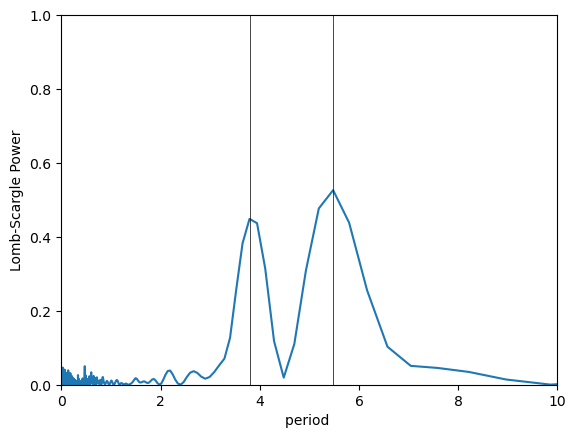

In [47]:
model = LombScargleFast().fit(t, x_3)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power')

ax.axvline(5.4782, color= 'black' ,lw=0.5)
ax.axvline(3.7926, color= 'black' ,lw=0.5);

In [48]:
power_sort = sorted(enumerate(power), key=itemgetter(1),  reverse=True)
index, value = power_sort[0]
print(r'La frecuencia encontrada es', 2*np.pi/periods[index])

La frecuencia encontrada es 1.1469352275523035


In [49]:
power2 = np.where(periods< 5, power, power*0)

pgram_sort = sorted(enumerate(power2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', 2*np.pi/periods[index])

La frecuencia encontrada es 1.6566842175755494


In [50]:
ls = LombScargle(t, x_3, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.5278208286248904
FAP = 4.099964640207562e-45


In [51]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.0657296 , 0.07048172, 0.08109802])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,0657; para el 5%, 0,07048, y para el 1%, 0,08109.

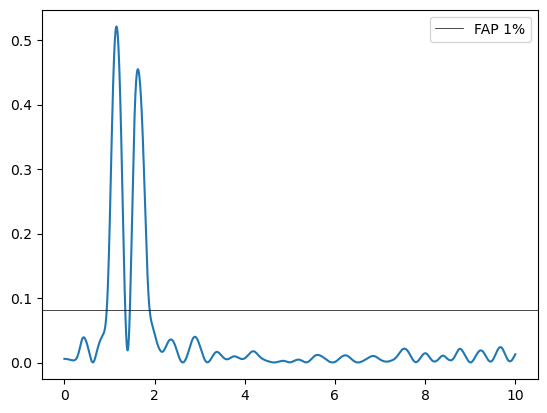

In [26]:
plt.plot(w,pgram)
plt.axhline(0.08109, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron dos picos con una FAP menos a 1%. 

#### Coordenada Y

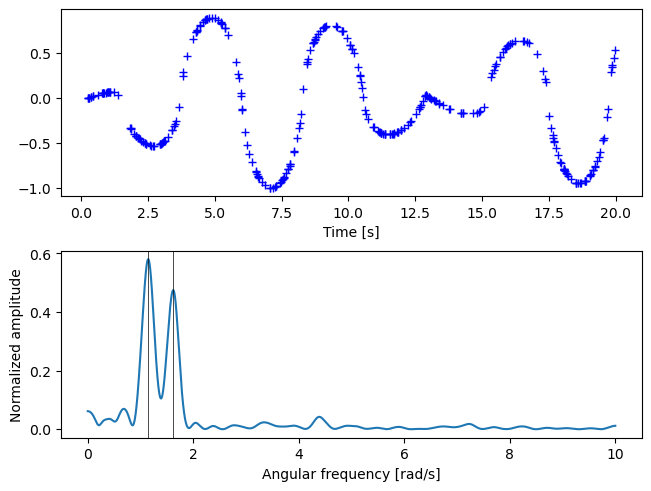

In [52]:
pgram = signal.lombscargle(t, y_3, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, y_3, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')

ax_w.axvline(1.1457, color= 'black' ,lw=0.5)
ax_w.axvline(1.6196, color= 'black' ,lw=0.5);

Buscamos el valor de la frecuencia del pico mas alto:

In [53]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.1457 0.0001


Buscamos el valor de la frecuencia del segundo pico:

In [54]:
pgram2 = np.where(w> 1.3, pgram, pgram*0)

pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],  err)

La frecuencia encontrada es 1.6196000000000002 0.0001


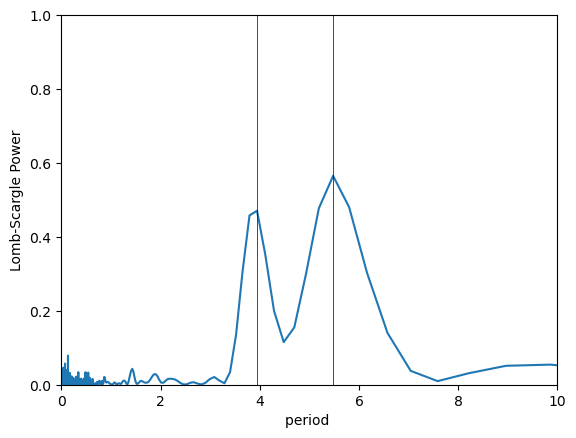

In [55]:
model = LombScargleFast().fit(t, y_3)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power')

ax.axvline(5.4782, color= 'black' ,lw=0.5)
ax.axvline(3.944, color= 'black' ,lw=0.5);

In [56]:
power_sort = sorted(enumerate(power), key=itemgetter(1),  reverse=True)
index, value = power_sort[0]
print(r'El periodo encontrado es', 2*np.pi/periods[index])

El periodo encontrado es 1.1469352275523035


In [57]:
power2 = np.where(periods< 5, power, power*0)

pgram_sort = sorted(enumerate(power2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', 2*np.pi/periods[index])

La frecuencia encontrada es 1.5929655938226437


In [47]:
ls = LombScargle(t, y_3, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.5650789821048271
FAP = 2.2106333134811763e-50


In [48]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.0657296 , 0.07048172, 0.08109802])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06547; para el 5%, 0,0704, y para el 1%, 0,08109.

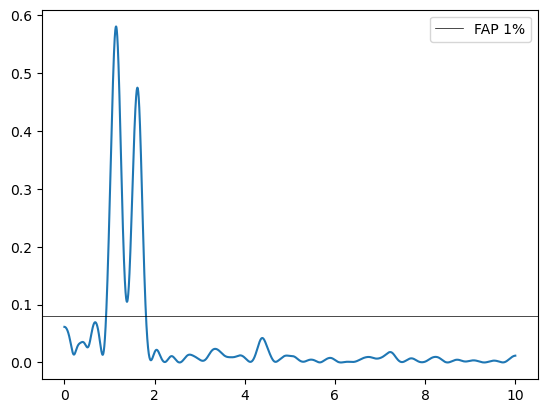

In [49]:
plt.plot(w,pgram)
plt.axhline(0.08109, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron dos picos con un FAP menor al 1%.

### Pasamos ahora a un potencial de la forma:

### $\phi = c(\frac{r_0}{r})^{\alpha}$

Resolvemos el sistema de ecuaciones diferenciales

In [58]:
# Elegimos los tiempos de observación t
seed_value = 40 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 20, n_in)

In [59]:
t.sort()

In [60]:
# Definimos el sistema de ecuaciones

def f(xyv_xv_y, t, c, r0, alpha):
    x, y, v_x, v_y = xyv_xv_y
    return [v_x, 
           v_y,
           -(c*alpha*x)*(r0/np.sqrt(x**2+y**2))**(alpha-1)*r0/(x**2+y**2)**(3/2),
           -(c*alpha*y)*(r0/np.sqrt(x**2+y**2))**(alpha-1)*r0/(x**2+y**2)**(3/2)]

c, r0, alpha = 1, 1, 0.5

# Condiciónes iniciales
xyv_xv_y0 = [1.0, 0., 0., 0.1]

# Resolvemos las ecuaciones
xyv_xv_y4 = integrate.odeint(f, xyv_xv_y0, t, args=(c, r0, alpha))

In [61]:
x_4 = xyv_xv_y4[:,0]
y_4 = xyv_xv_y4[:,1]
v_x_4 = xyv_xv_y4[:,2]
v_y_4 = xyv_xv_y4[:,3]

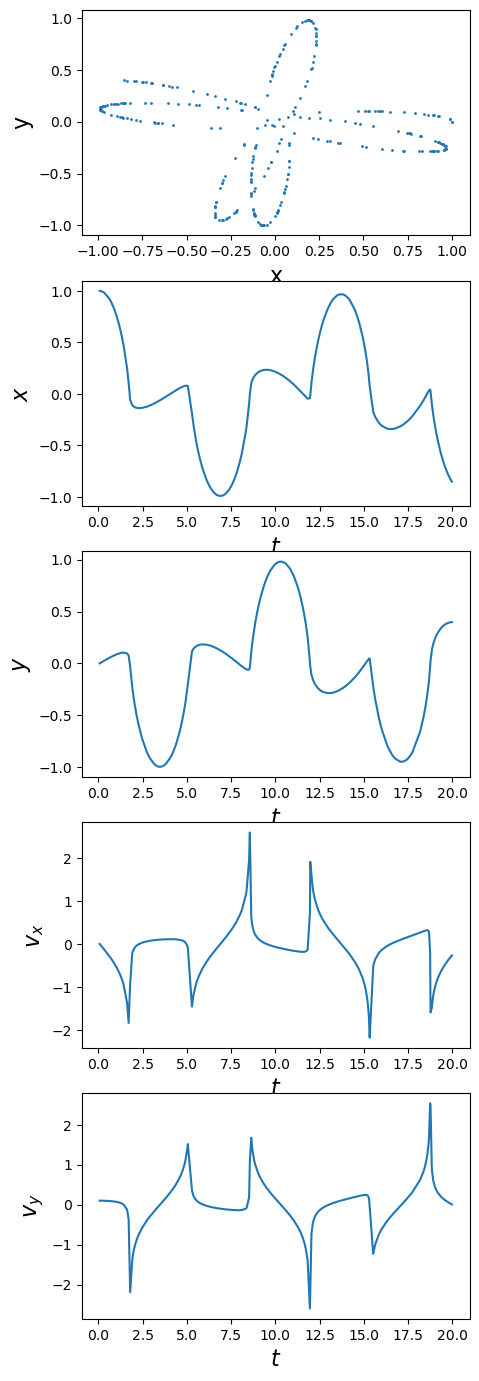

In [62]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(x_4,y_4, 'o', ms=1)
ax2.plot(t, x_4)
ax3.plot(t, y_4)
ax4.plot(t, v_x_4)
ax5.plot(t, v_y_4)

ax1.set_ylabel('y', fontsize=16)
ax1.set_xlabel('x', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax4.set_ylabel('$v_x$', fontsize=16)
ax5.set_ylabel('$v_y$', fontsize=16);

Calculamos el periodograma para las coordenadas x e y:

#### Coordenada X

In [63]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.0002, 20, n_out)
periods = 2 * np.pi / w

# Calculamos el error en frecuencia
err= w[1]-w[0]
err

0.0002

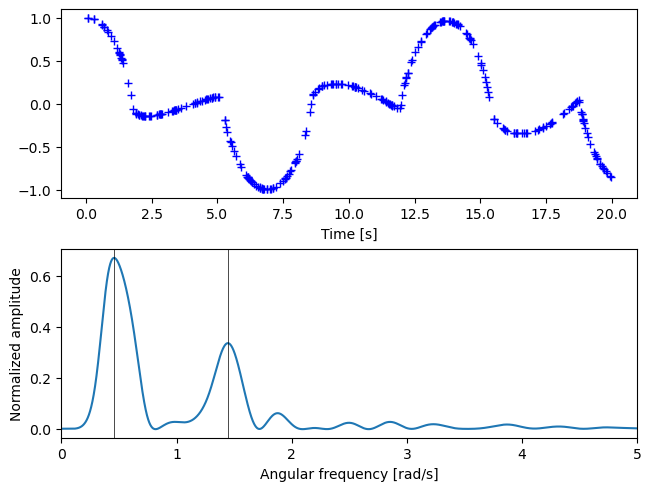

In [64]:
pgram = signal.lombscargle(t, x_4, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x_4, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
ax_w.set_xlim(0,5)

ax_w.axvline(0.4574, color= 'black' ,lw=0.5)
ax_w.axvline(1.4456, color= 'black' ,lw=0.5);

Buscamos el valor de la frecuencia del pico mas alto:

In [65]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 0.4574 0.0002


Buscamos el valor de la frecuencia del segundo pico:

In [66]:
pgram2 = np.where(w> 1., pgram, pgram*0)

pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.4456 0.0002


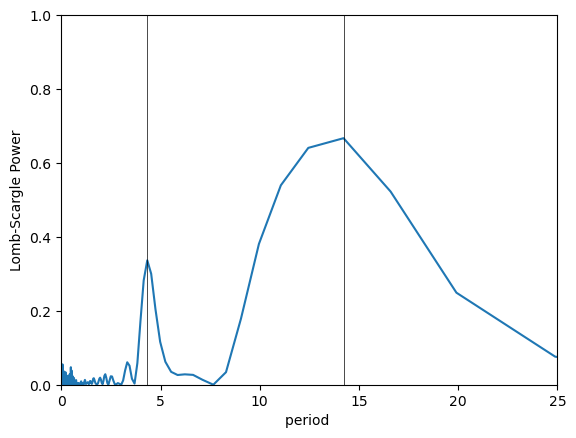

In [67]:
model = LombScargleFast().fit(t, x_4)
periods, power = model.periodogram_auto(nyquist_factor=20)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 25), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power')

ax.axvline(14.2218, color= 'black' ,lw=0.5)
ax.axvline(4.3283, color= 'black' ,lw=0.5);

In [68]:
power_sort = sorted(enumerate(power), key=itemgetter(1),  reverse=True)
index, value = power_sort[0]
print(r'La frecuencia encontrada es', 2*np.pi/periods[index])

La frecuencia encontrada es 0.4417983361176308


In [69]:
power2 = np.where(periods< 7, power, power*0)

pgram_sort = sorted(enumerate(power2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', 2*np.pi/periods[index])

La frecuencia encontrada es 1.4516231043865013


In [70]:
ls = LombScargle(t, x_4, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.6717306817180779
FAP = 1.9466932946782256e-68


In [71]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.06557543, 0.07032889, 0.08094792])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06557; para el 5%, 0,07032, y para el 1%, 0,0809.

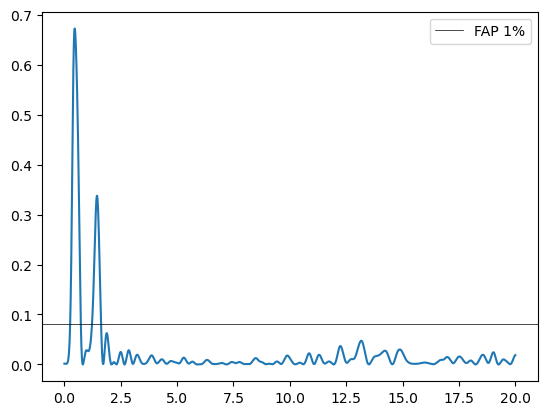

In [72]:
plt.plot(w,pgram)
plt.axhline(0.08094, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron dos picos con una FAP menos a 1%. 

#### Coordenada Y

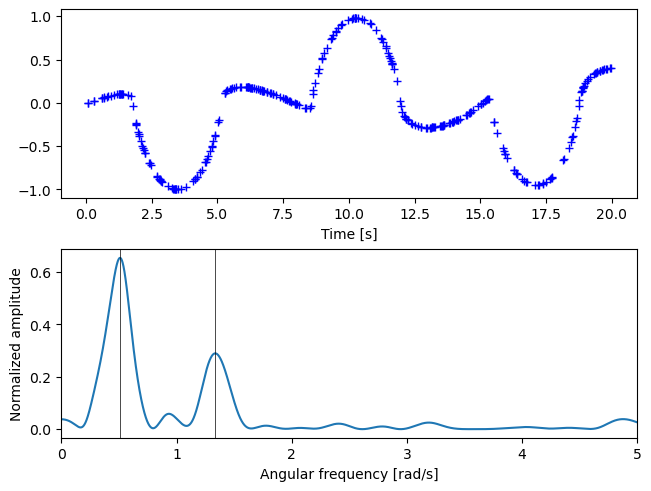

In [73]:
pgram = signal.lombscargle(t, y_4, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, y_4, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
ax_w.set_xlim(0,5)

ax_w.axvline(0.5092, color= 'black' ,lw=0.5)
ax_w.axvline(1.336, color= 'black' ,lw=0.5);

Buscamos el valor de la frecuencia del pico mas alto:

In [74]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 0.5092 0.0002


Buscamos el valor de la frecuencia del segundo pico:

In [75]:
pgram2 = np.where(w> 1, pgram, pgram*0)

pgram_sort = sorted(enumerate(pgram2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],  err)

La frecuencia encontrada es 1.336 0.0002


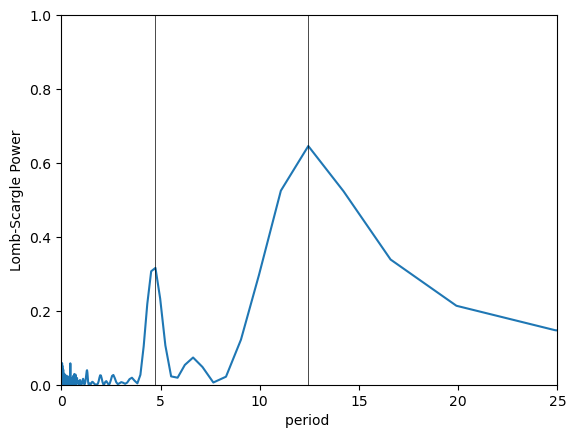

In [79]:
model = LombScargleFast().fit(t, y_4)
periods, power = model.periodogram_auto(nyquist_factor=20)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 25), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power')

ax.axvline(12.444, color= 'black' ,lw=0.5)
ax.axvline(4.7406, color= 'black' ,lw=0.5);

In [77]:
power_sort = sorted(enumerate(power), key=itemgetter(1),  reverse=True)
index, value = power_sort[0]
print(r'El periodo encontrado es', 2*np.pi/periods[index])

El periodo encontrado es 0.5049123841344353


In [80]:
power2 = np.where(periods< 7, power, power*0)

pgram_sort = sorted(enumerate(power2), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', 2*np.pi/periods[index])

La frecuencia encontrada es 1.3253950083528925


In [81]:
ls = LombScargle(t, y_4, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.646081832021924
FAP = 1.307329511644132e-63


In [82]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.06557543, 0.07032889, 0.08094792])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06557; para el 5%, 0,07032, y para el 1%, 0,08094.

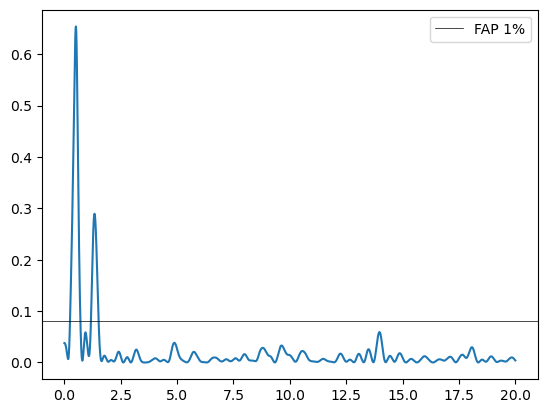

In [83]:
plt.plot(w,pgram)
plt.axhline(0.08094, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron dos picos con una FAP menos a 1%. 

## Pasamos ahora a potenciales con simetria axial

### $\phi(r,z)= \frac{V_o^2}{2}ln(R_c²+r²+\frac{z²}{q²})$ 
#### $\frac{1}{\sqrt{2}}<q\leqslant1$ 

Resolvemos el sistema de ecuaciones diferenciales

In [84]:
# Elegimos los tiempos de observación t
seed_value = 50 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 20, n_in)

In [85]:
t.sort()

In [86]:
# Definimos el sistema de ecuaciones

def f(rzv_rv_z, t, vo, Rc, q):
    r, z, v_r, v_z = rzv_rv_z
    return [v_r, 
           v_z,
            (-vo**2 *r)/(Rc**2 + r**2 + (z/q)**2),
            (-vo**2 *z)/(q**2) * ((Rc**2 + r**2 + (z/q)**2))]

vo, Rc, q = 1, 1, 0.8

# Condiciónes iniciales
rzv_rv_z0 = [1, 0.5, 0, 1]

# Resolvemos las ecuaciones
rzv_rv_z1 = integrate.odeint(f, rzv_rv_z0, t, args=(vo, Rc, q))

In [87]:
r1 = rzv_rv_z1[:,0]
z1 = rzv_rv_z1[:,1]
v_r1 = rzv_rv_z1[:,2]
v_z1 = rzv_rv_z1[:,3]

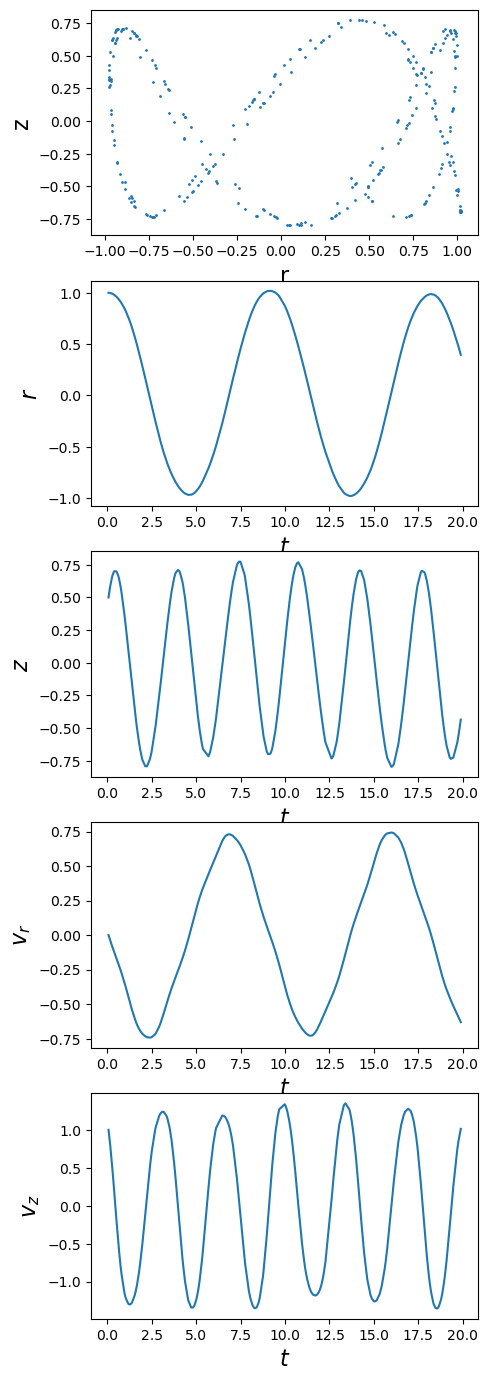

In [88]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(r1,z1, 'o', ms=1)
ax2.plot(t, r1)
ax3.plot(t, z1)
ax4.plot(t, v_r1)
ax5.plot(t, v_z1)

ax1.set_ylabel('z', fontsize=16)
ax1.set_xlabel('r', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$r$', fontsize=16)
ax3.set_ylabel('$z$', fontsize=16)
ax4.set_ylabel('$v_r$', fontsize=16)
ax5.set_ylabel('$v_z$', fontsize=16);

#### Coordenada r

In [93]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.0001, 10, n_out)
periods = 2 * np.pi / w

# Calculamos el error en frecuencia
err= w[1]-w[0]
err

0.0001

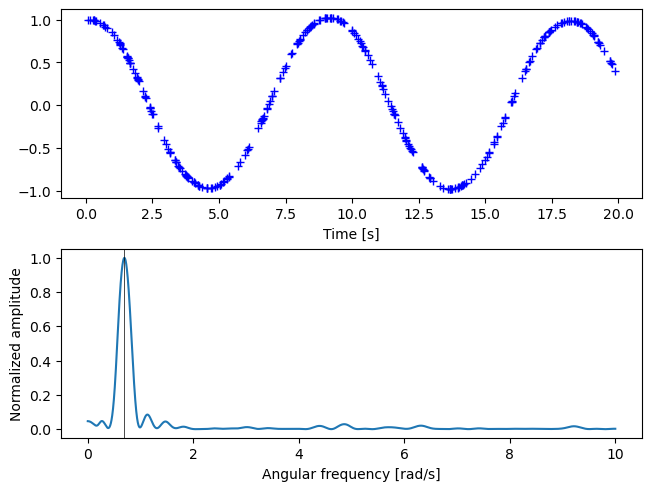

In [94]:
pgram = signal.lombscargle(t, r1, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, r1, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')

ax_w.axvline(0.6944, color= 'black' ,lw=0.5);

Buscamos el valor de la frecuencia del pico mas alto:

In [91]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 0.6944 0.0001


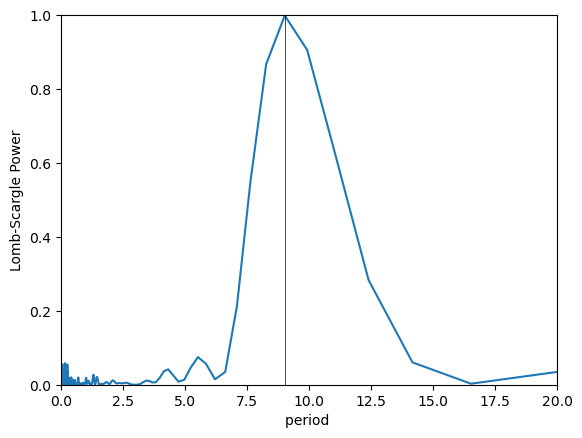

In [98]:
model = LombScargleFast().fit(t, r1)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 20), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power')

ax.axvline(9.0079, color= 'black' ,lw=0.5);

In [99]:
power_sort = sorted(enumerate(power), key=itemgetter(1),  reverse=True)
index, value = power_sort[0]
print(r'La frecuencia encontrada es', 2*np.pi/periods[index])

La frecuencia encontrada es 0.6975170715370177


In [100]:
ls = LombScargle(t, r1, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.9993072638309289
FAP = 0.0


In [101]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.06569807, 0.07045046, 0.08106733])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06569; para el 5%, 0,07045, y para el 1%, 0,08106.

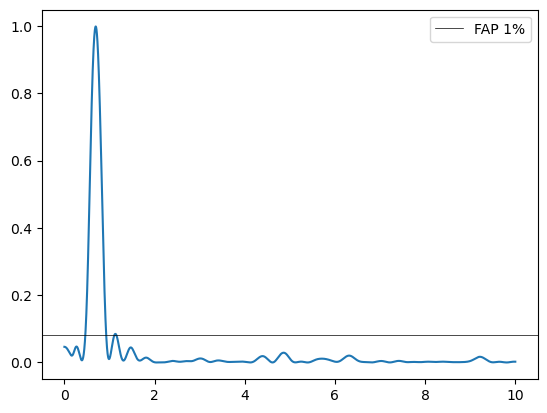

In [103]:
plt.plot(w,pgram)
plt.axhline(0.08106, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron (uno o dos?) picos con una FAP menos a 1%. 

#### Coordenada Z

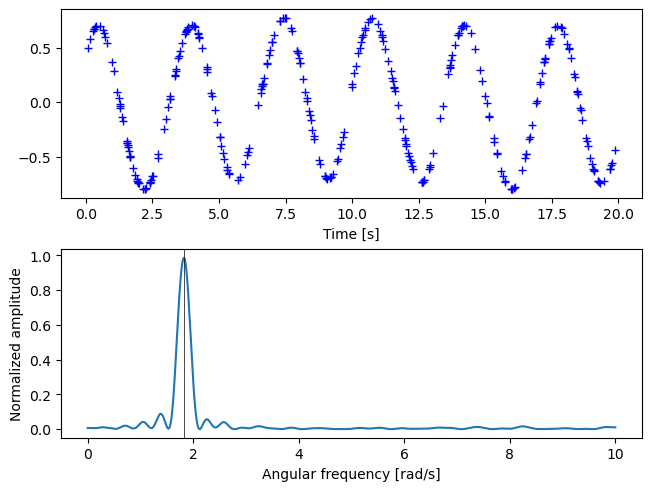

In [106]:
pgram = signal.lombscargle(t, z1, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, z1, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')

ax_w.axvline(1.8224, color= 'black' ,lw=0.5);

Buscamos el valor de la frecuencia del pico mas alto:

In [105]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 1.8224 0.0001


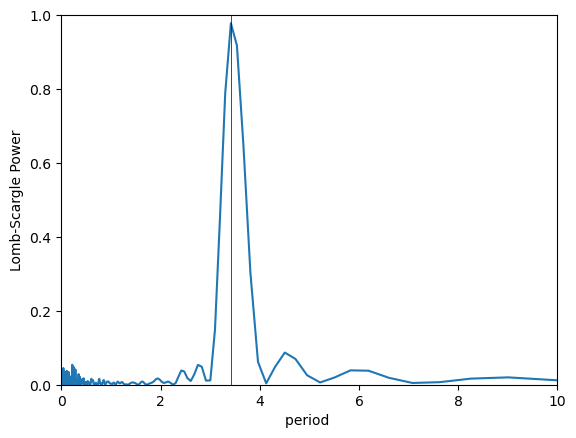

In [109]:
model = LombScargleFast().fit(t, z1)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power')

ax.axvline(3.4168, color= 'black' ,lw=0.5);

In [110]:
power_sort = sorted(enumerate(power), key=itemgetter(1),  reverse=True)
index, value = power_sort[0]
print(r'El periodo encontrado es', 2*np.pi/periods[index])

El periodo encontrado es 1.8389086431430468


In [111]:
ls = LombScargle(t, z1, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.9868717159811393
FAP = 2.9753129431614425e-275


In [112]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.06569807, 0.07045046, 0.08106733])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06569; para el 5%, 0,0704, y para el 1%, 0,08106.

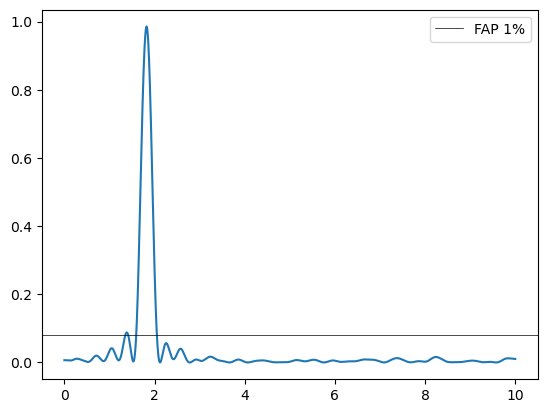

In [113]:
plt.plot(w,pgram)
plt.axhline(0.08106, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron (uno o dos?) picos con una FAP menos a 1%. 

### Por último con
### $\phi(r,z)= \frac{V_o^2}{2}ln(R_c²+r²+\frac{z²}{q²} - \sqrt{(r²+z²)}(r²-z²)/R_e)$ 
#### $\frac{1}{\sqrt{2}}<q\leqslant1$ 
$R_e = 1$

In [115]:
# Elegimos los tiempos de observación t
seed_value = 60 
rng = np.random.default_rng(seed_value)

t = rng.uniform(0, 20, n_in)

In [116]:
t.sort()

In [120]:
# Definimos el sistema de ecuaciones

def f(rzv_rv_z, t, vo, Rc, q):
    r, z, v_r, v_z = rzv_rv_z
    return [v_r, 
            v_z,
            -vo**2*(-2*r*np.sqrt(r**2+z**2)-((r*(r**2-z**2))/np.sqrt(r**2+z**2))+2*r) / 
            2*(Rc**2+(z/q)**2-((r**2-z**2)*np.sqrt(r**2+z**2))+r**2),  
            
            -vo**2*(2*z*np.sqrt(r**2+z**2)-((z*(r**2-z**2))/np.sqrt(r**2+z**2))+2*z/q**2) / 
            2*(Rc**2+(z/q)**2-((r**2-z**2)*np.sqrt(r**2+z**2))+r**2)]  

vo, Rc, q = 1, 1, 0.8

# Condiciónes iniciales
rzv_rv_z0 = [0.5, 1, 0.1, 0.2]

# Resolvemos las ecuaciones
rzv_rv_z2 = integrate.odeint(f, rzv_rv_z0, t, args=(vo, Rc, q))

NO HACER CASO A ESTA CELDA!!!!!!!


# Definimos el sistema de ecuaciones

def f(rzv_rv_z, t, q, vo, Rc):
    r, z, v_r, v_z = rzv_rv_z
    return [v_r, 
            v_z,
            -vo**2*(-2*r*np.sqrt(r**2+z**2)-((r*(r**2-z**2))/np.sqrt(r**2+z**2))+2*r) / 
            2*(Rc**2+(z/q)**2-((r**2-z**2)*np.sqrt(r**2+z**2))+r**2),  
            
            -vo**2*(2*z*np.sqrt(r**2+z**2)-((z*(r**2-z**2))/np.sqrt(r**2+z**2))+2*z/q**2) / 
            2*(Rc**2+(z/q)**2-((r**2-z**2)*np.sqrt(r**2+z**2))+r**2)]  

q, vo, Rc = 0.8, 1, 1

# Condiciónes iniciales
rzv_rv_z0 = [0.5, 1, 0.1, 0.2]

# Resolvemos las ecuaciones
rzv_rv_z2 = integrate.odeint(f, rzv_rv_z0, t, args=(q, Rc, vo))

In [121]:
r2 = rzv_rv_z2[:,0]
z2 = rzv_rv_z2[:,1]
v_r2 = rzv_rv_z2[:,2]
v_z2 = rzv_rv_z2[:,3]

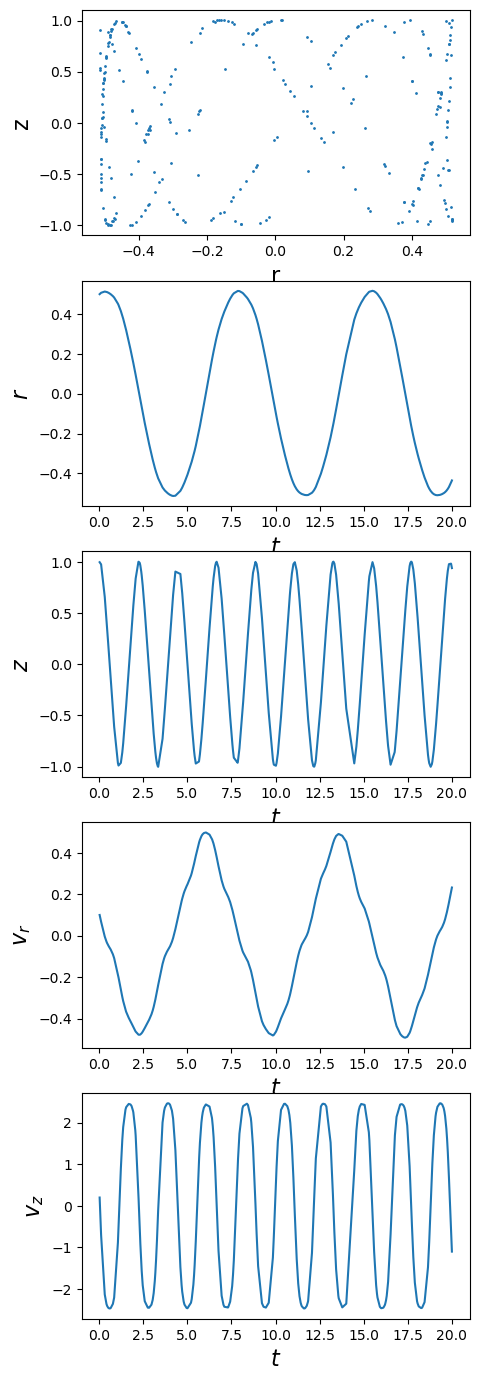

In [122]:
# Graficamos las soluciones

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(5,17))

ax1.plot(r2,z2, 'o', ms=1)
ax2.plot(t, r2)
ax3.plot(t, z2)
ax4.plot(t, v_r2)
ax5.plot(t, v_z2)

ax1.set_ylabel('z', fontsize=16)
ax1.set_xlabel('r', fontsize=16)
ax2.set_xlabel('$t$', fontsize=16)
ax3.set_xlabel('$t$', fontsize=16)
ax4.set_xlabel('$t$', fontsize=16)
ax5.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$r$', fontsize=16)
ax3.set_ylabel('$z$', fontsize=16)
ax4.set_ylabel('$v_r$', fontsize=16)
ax5.set_ylabel('$v_z$', fontsize=16);

NOTA: LAS CONDICIONES INICIALES ME CAMBIAN MUCHO LA FORMA DE LAS ORBITAS, CON CAMBIARLAS UN POCO LAS ORBITAS PARECEN "IRSE"

#### Coordenada r

In [123]:
# Definimos el espacio de frecuencias a analizar

w = np.linspace(0.0001, 10, n_out)
periods = 2 * np.pi / w

# Calculamos el error en frecuencia
err= w[1]-w[0]
err

0.0001

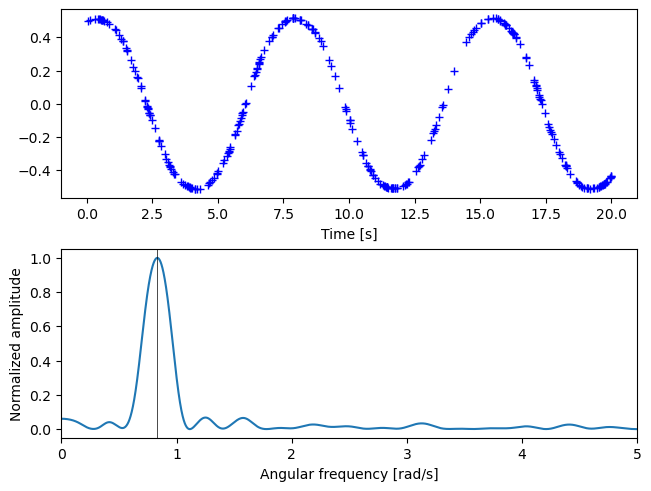

In [128]:
pgram = signal.lombscargle(t, r2, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, r2, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
ax_w.set_xlim(0,5)

ax_w.axvline(0.8328, color= 'black' ,lw=0.5);

Buscamos el valor de la frecuencia del pico mas alto:

In [129]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 0.8328 0.0001


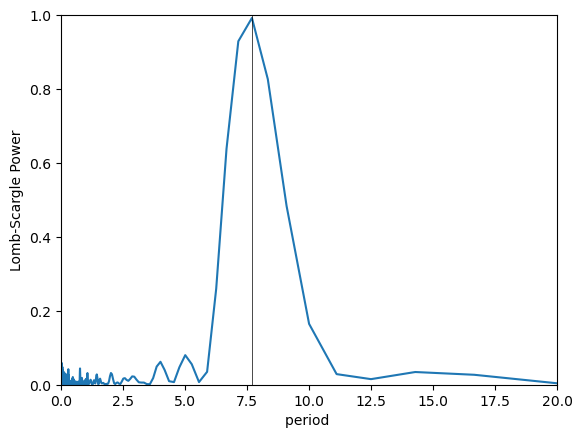

In [132]:
model = LombScargleFast().fit(t, r2)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 20), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power')

ax.axvline(7.6825, color= 'black' ,lw=0.5);

In [133]:
power_sort = sorted(enumerate(power), key=itemgetter(1),  reverse=True)
index, value = power_sort[0]
print(r'La frecuencia encontrada es', 2*np.pi/periods[index])

La frecuencia encontrada es 0.8178469292760441


In [134]:
ls = LombScargle(t, x_3, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.4282147112440446
FAP = 7.569271301867827e-33


In [135]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([0.06586706, 0.07061798, 0.08123186])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06586; para el 5%, 0,07061, y para el 1%, 0,08123.

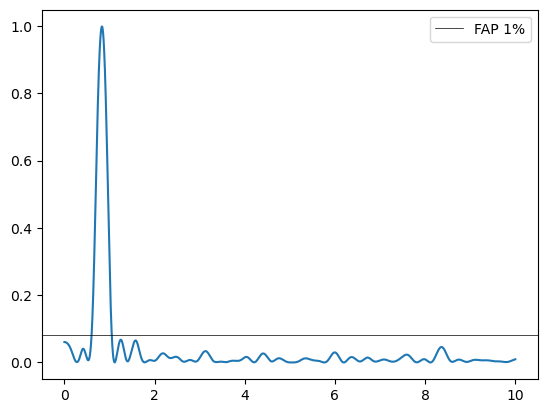

In [137]:
plt.plot(w,pgram)
plt.axhline(0.08123, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontro un pico con una FAP menos a 1%. 

#### Coordenada Z

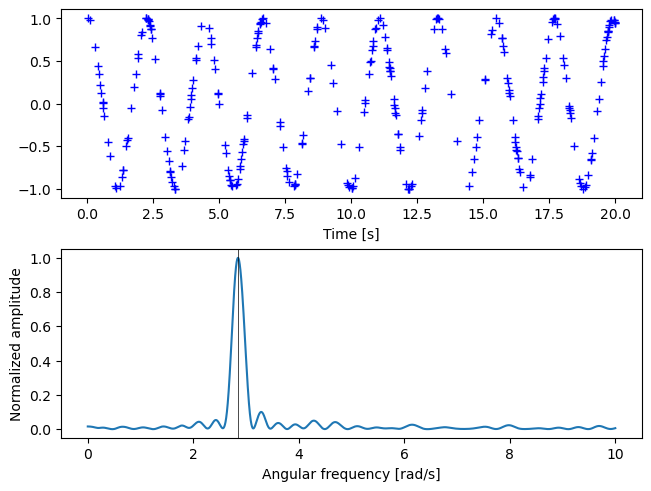

In [140]:
pgram = signal.lombscargle(t, z2, w, normalize=True)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, z2, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')

ax_w.axvline(2.8478, color= 'black' ,lw=0.5);

Buscamos el valor de la frecuencia del pico mas alto:

In [141]:
pgram_sort = sorted(enumerate(pgram), key=itemgetter(1),  reverse=True)
index, value = pgram_sort[0]
print(r'La frecuencia encontrada es', w[index],   err)

La frecuencia encontrada es 2.8478000000000003 0.0001


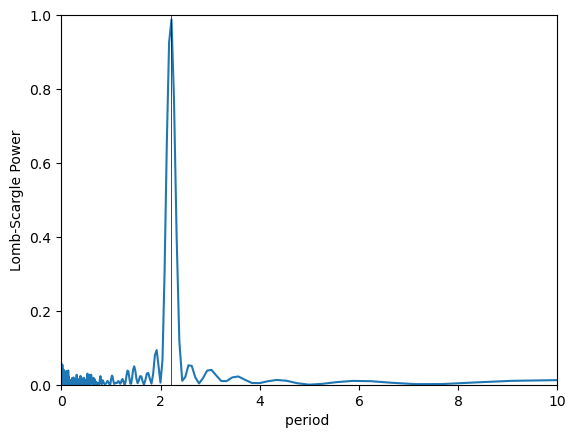

In [144]:
model = LombScargleFast().fit(t, z2)
periods, power = model.periodogram_auto(nyquist_factor=10)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1),
        xlabel='period ',
        ylabel='Lomb-Scargle Power')

ax.axvline(2.2194, color= 'black' ,lw=0.5);

In [145]:
power_sort = sorted(enumerate(power), key=itemgetter(1),  reverse=True)
index, value = power_sort[0]
print(r'El periodo encontrado es', 2*np.pi/periods[index])

El periodo encontrado es 2.831008601340152


In [146]:
ls = LombScargle(t, z2, normalization='standard')
power = ls.power(w)
print(power.max())  

fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

0.9985052785490983
FAP = 0.0


In [147]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities) 

array([0.06586706, 0.07061798, 0.08123186])

Vemos entonces que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,06586; para el 5%, 0,07061, y para el 1%, 0,08123.

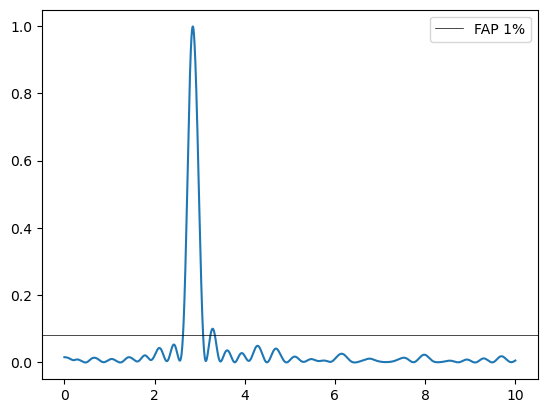

In [148]:
plt.plot(w,pgram)
plt.axhline(0.08123, color= 'black' ,lw=0.5, label=('FAP 1%'))
plt.legend(loc = 'upper right');

- Vemos entonces que se encontraron (uno o dos?) picos con una FAP menos a 1%. 